In [2]:
import sys
sys.path.append('/insomnia001/home/wm2377/cdwm/large_effect_alleles/scripts/individual_classes.py')
import individual_classes as classes
import pickle
import numpy as np
from scipy import stats
from scipy.integrate import quad
import os
from matplotlib import pyplot as plt
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
from collections import defaultdict as ddict
#import mpatches
import matplotlib as mpl
import matplotlib.patches as mpatches
#import lines2D
import matplotlib.lines as mlines

import gzip


In [3]:
# Assign a color based on sigma2 and shift values for 2NU x-axis plots
def color_function_2NU_x_axis(sigma2, shift):
    if sigma2 == 80:
        if shift == 80:
            color = 'cornflowerblue'
        else:
            color = 'lightcoral'
    elif sigma2 == 40:
        if shift == 80:
            color = 'purple'
        else:
            color = 'darkorange'
    elif sigma2 == 4:
        if shift == 80:
            color = 'brown'
        else:
            color = 'forestgreen'
    
    return color


In [4]:
# read in results from individual-based simulations
fixation_results = {}
for sigma2 in [4]:
    fixation_results[sigma2] = {}
    for shift in [50,80]:
        fixation_results[sigma2][shift] = {}
        for N2U in np.logspace(-3,3,13):
            fixation_results[sigma2][shift][N2U] = [0,0,0]
            for iteration in range(100):
                i = f'/insomnia001/home/wm2377/cdwm/large_effect_alleles/data/individual_simulations/sigma2_{sigma2}/LargeN2U_{N2U}/shift_{shift}/iteration_{iteration}_population.pkl'
                if not os.path.exists(i):
                    continue
                with open(i, 'rb') as popfile:
                    population = pickle.load(popfile)
                fixations = population[0].fixations
                fixations = [1 for (m,t) in fixations if t > 0 and m.a >= 10]
                n_fix = sum(fixations)
                fixation_results[sigma2][shift][N2U][0] += n_fix
                fixation_results[sigma2][shift][N2U][1] += n_fix**2
                fixation_results[sigma2][shift][N2U][2] += 1


In [5]:
# Plot individual-based simulation results
# here, we plot the mean number of fixations +/- standard error
# for each combination of sigma2, shift, and N2U
def plot_individual_fixations(ax1):
    for sigma2 in fixation_results:
        for shift in fixation_results[sigma2]:
            color = color_function_2NU_x_axis(sigma2, shift)
            for N2U in fixation_results[sigma2][shift]:
                n_fix = fixation_results[sigma2][shift][N2U][0]
                n_fix_sq = fixation_results[sigma2][shift][N2U][1]
                n_iter = fixation_results[sigma2][shift][N2U][2]
                if n_iter == 0:
                    continue
                mean = n_fix / n_iter
                var = (n_fix_sq/n_iter - mean**2)
                std = np.sqrt(var)
                ste = std / np.sqrt(n_iter)
                ax1.errorbar(N2U, mean, yerr=ste, marker='+',color=color)


In [12]:
# Function to read in processed simulation data
def get_processed_data(simulation_type, sigma2_values, large_2NU_values, shift_values):
    processed_results = {sigma2: {large_2NU: {shift: [] for shift in shift_values} for large_2NU in large_2NU_values} for sigma2 in sigma2_values}
    for sigma2 in sigma2_values:
        for large_2NU in large_2NU_values:
            for shift in shift_values:
                filepath = f"/insomnia001/home/wm2377/cdwm/large_effect_alleles/data/{simulation_type}_simulations/sigma2_{sigma2}/LargeN2U_{large_2NU}/shift_{shift}/all_processed_results_with_mutation_counts.pkl"
                if os.path.exists(filepath):
                    with open(filepath, 'rb') as f:
                        all_iterations_data = pickle.load(f)
                        fixations = pickle.load(f)
                    processed_results[sigma2][large_2NU][shift] = (all_iterations_data,fixations)
                else:
                    print(f"File not found: {filepath}")
                    processed_results[sigma2][large_2NU].pop(shift)
    return processed_results


In [13]:
# Plot variance and skew grouped by 2NU values
def plot_var_and_skew_group_2NU(axes,results,bin_value = 100):
    # Unpack axes
    ax1, ax2, ax3, ax4 = axes
    # Group data by 2NU values, reorder keys for easier plotting
    grouped_data = {}
    for sigma2 in results.keys():
        if sigma2 not in grouped_data:
            grouped_data[sigma2] = {}
        for large_2NU in results[sigma2].keys():
            for shift in results[sigma2][large_2NU].keys():
                if shift not in grouped_data[sigma2]:
                    grouped_data[sigma2][shift] = {}
                grouped_data[sigma2][shift][large_2NU] = results[sigma2][large_2NU][shift]
        
    # Now plot grouped by 2NU values                
    for sigma2 in grouped_data.keys():
        for shift in grouped_data[sigma2].keys():
            large_2NU_values = list(grouped_data[sigma2][shift].keys())
            if len(large_2NU_values) == 0:
                continue
            ll = 20000
            
            # get the large and small 2NU values
            large_large_2NU_values = [large_2NU for large_2NU in large_2NU_values if large_2NU > 1]
            small_large_2NU_values = [large_2NU for large_2NU in large_2NU_values if large_2NU <= 1]
            
            # calculate mean and ste for each group
            for group_values,alpha in zip([large_large_2NU_values, small_large_2NU_values],[1,0.25]):
                sum_values_group = {'variance':np.zeros(ll),'skew':np.zeros(ll)}
                sum_squared_values_group = {'variance':np.zeros(ll),'skew':np.zeros(ll)}
                n_values_group = {'variance':np.zeros(ll),'skew':np.zeros(ll)}
                for large_2NU in group_values:
                    data,fixations = grouped_data[sigma2][shift][large_2NU]
    
                    
                    time_values = np.sort(list(data.keys()))
                    color = color_function_2NU_x_axis(sigma2, shift)
                    for metric,scalar,ax in zip(['variance','skew'],[sigma2,2*sigma2],[ax1,ax2]):
                        

                        sum_values = [data[t][bin_value][metric]['sum'] for t in time_values]
                        sum_squared_values = [data[t][bin_value][metric]['sum_sq'] for t in time_values]
                        n_values = [data[t][bin_value][metric]['count'] for t in time_values]
                        
                        l = min(len(sum_values),ll)
                        sum_values_group[metric][:l] += np.array(sum_values[:l])
                        sum_squared_values_group[metric][:l] += np.array(sum_squared_values[:l])
                        n_values_group[metric][:l] += np.array(n_values[:l])
                    
                # plot variance with error bars
                if alpha == 1:
                    axes_here = (ax1, ax2)
                else:
                    axes_here = (ax3, ax4)
                for metric,scalar,ax in zip(['variance'],[sigma2,4*sigma2],axes_here):
                    time_values = np.arange(ll)
                    sum_values = sum_values_group[metric]
                    sum_squared_values = sum_squared_values_group[metric]
                    n_values = n_values_group[metric]
                    mean_values = np.array([s/n if n > 0 else np.nan for s, n in zip(sum_values, n_values)])/scalar
                    error_values = np.array([2*np.sqrt((s/n-(m/n)**2)/n) if n > 0 else np.nan for s, m, n in zip(sum_squared_values, sum_values, n_values)])/scalar
                    ax.fill_between(time_values, np.array(mean_values) - np.array(error_values), np.array(mean_values) + np.array(error_values), alpha=0.2,color=color)
                    ax.plot(time_values, mean_values,color=color,alpha=1)

# Plot all-allele fixations for comparison with individual-based simulations
def plot_all_allele_fixations(tx1,results,bin_value = 100):

    grouped_data = {}
    for sigma2 in results.keys():
        if sigma2 not in grouped_data:
            grouped_data[sigma2] = {}
        for large_2NU in results[sigma2].keys():
            for shift in results[sigma2][large_2NU].keys():
                if shift not in grouped_data[sigma2]:
                    grouped_data[sigma2][shift] = {}
                grouped_data[sigma2][shift][large_2NU] = results[sigma2][large_2NU][shift]
                data,fixations = results[sigma2][large_2NU][shift]
                
                # calculate mean and ste for fixations
                fixations_store = {'aligned_small':{'sum':0,'sum_sq':0,'count':0},
                                    'aligned_large':{'sum':0,'sum_sq':0,'count':0},
                                    'opposing_small':{'sum':0,'sum_sq':0,'count':0}}
                
                for key in fixations:
                    n_fix_aligned_small = sum([1 for f in fixations[key] if f < 10 and f > 0])
                    n_fix_aligned_large = sum([1 for f in fixations[key] if f >= 10])
                    n_fix_opposing_small = sum([1 for f in fixations[key] if f < 0])
                    
                    fixations_store['aligned_small']['sum'] += n_fix_aligned_small
                    fixations_store['aligned_small']['sum_sq'] += n_fix_aligned_small**2
                    fixations_store['aligned_small']['count'] += 1
                    fixations_store['aligned_large']['sum'] += n_fix_aligned_large
                    fixations_store['aligned_large']['sum_sq'] += n_fix_aligned_large**2
                    fixations_store['aligned_large']['count'] += 1
                    fixations_store['opposing_small']['sum'] += n_fix_opposing_small
                    fixations_store['opposing_small']['sum_sq'] += n_fix_opposing_small**2
                    fixations_store['opposing_small']['count'] += 1
                    
                # plot number of large-effect fixations with error bars
                for key_fix in fixations_store:
                    if 'large' not in key_fix:
                        continue
                    if fixations_store[key_fix]['count'] > 0:
                        mean = fixations_store[key_fix]['sum'] / fixations_store[key_fix]['count']
                        ste = np.sqrt(2*((fixations_store[key_fix]['sum_sq'] / fixations_store[key_fix]['count']) - (mean**2))/ fixations_store[key_fix]['count'])
                        if 'aligned' in key_fix:
                            if 'small' in key_fix:
                                color = 'forestgreen'
                            else:
                                color = 'darkorange'
                        else:
                            color = 'blue'
                        color = color_function_2NU_x_axis(sigma2, shift)
                        if sigma2 == 4:
                            tx1.errorbar(large_2NU,mean,yerr=ste,fmt='o',label=key_fix,alpha=0.2,color=color)
                            tx1.set_xscale('log')
                
    

In [14]:
# Read in processed data for all-allele simulations
sigma2_values = [4,40,80]
large_2NU_values = np.logspace(-3,3,13)[:-1]
shift_values = [50,80]
all_allele_results = get_processed_data(simulation_type='all_allele', sigma2_values=sigma2_values, shift_values=shift_values, large_2NU_values=large_2NU_values)


In [15]:
# Plot skew from all-allele based simulations
def plot_skew(ax_small,ax_large):
    binned_results = {}
    for sigma2 in [4,40,80]:
        if sigma2 not in binned_results:
            binned_results[sigma2] = {}
        for shift in [50,80]:
            if shift not in binned_results[sigma2]:
                binned_results[sigma2][shift] = {'large':[], 'small':[]}
            for large_2NU in np.logspace(-3,3,13):
                file_path = f"/insomnia001/home/wm2377/cdwm/large_effect_alleles/data/all_alleles_simulations/sigma2_{sigma2}/LargeN2U_{large_2NU}/shift_{shift}/better_skew_results.pkl"
                if os.path.exists(file_path):
                    with open(file_path, 'rb') as f:
                        better_skew_results = pickle.load(f)
                    
                    for (sigma2,shift,N2U),(mean,ste) in better_skew_results.items():
                        color = color_function_2NU_x_axis(sigma2, shift)
                        mean = np.array(mean)
                        ste = np.array(ste)
                        if N2U >= 1:
                            binned_results[sigma2][shift]['large'].append((mean,ste))
                        else:
                            binned_results[sigma2][shift]['small'].append((mean,ste))
                else:
                    print(f"File not found: {file_path}")

    for sigma2 in binned_results:
        for shift in binned_results[sigma2]:
            for size,ax in zip(['large','small'],[ax_large,ax_small]):
                mean_array,ste_array = zip(*binned_results[sigma2][shift][size])
                color = color_function_2NU_x_axis(sigma2, shift)
                mean_values = np.nanmean(mean_array,axis=0)/(2*sigma2)
                ste_values = np.nanmean(ste_array,axis=0)/np.sqrt(len(ste_array))/(2*sigma2)
                ax.fill_between(np.linspace(-1,20000,len(mean_values)), mean_values - ste_values, mean_values + ste_values, alpha=0.2,color=color)
                ax.plot(np.linspace(-1,20000,len(mean_values)), mean_values,color=color,alpha=1)
                
    for ax in [ax_small, ax_large]:
        ax.set_xscale('log')
        ax.set_ylim(-0.05,0.05)
        ax.set_xlim(1,19990)



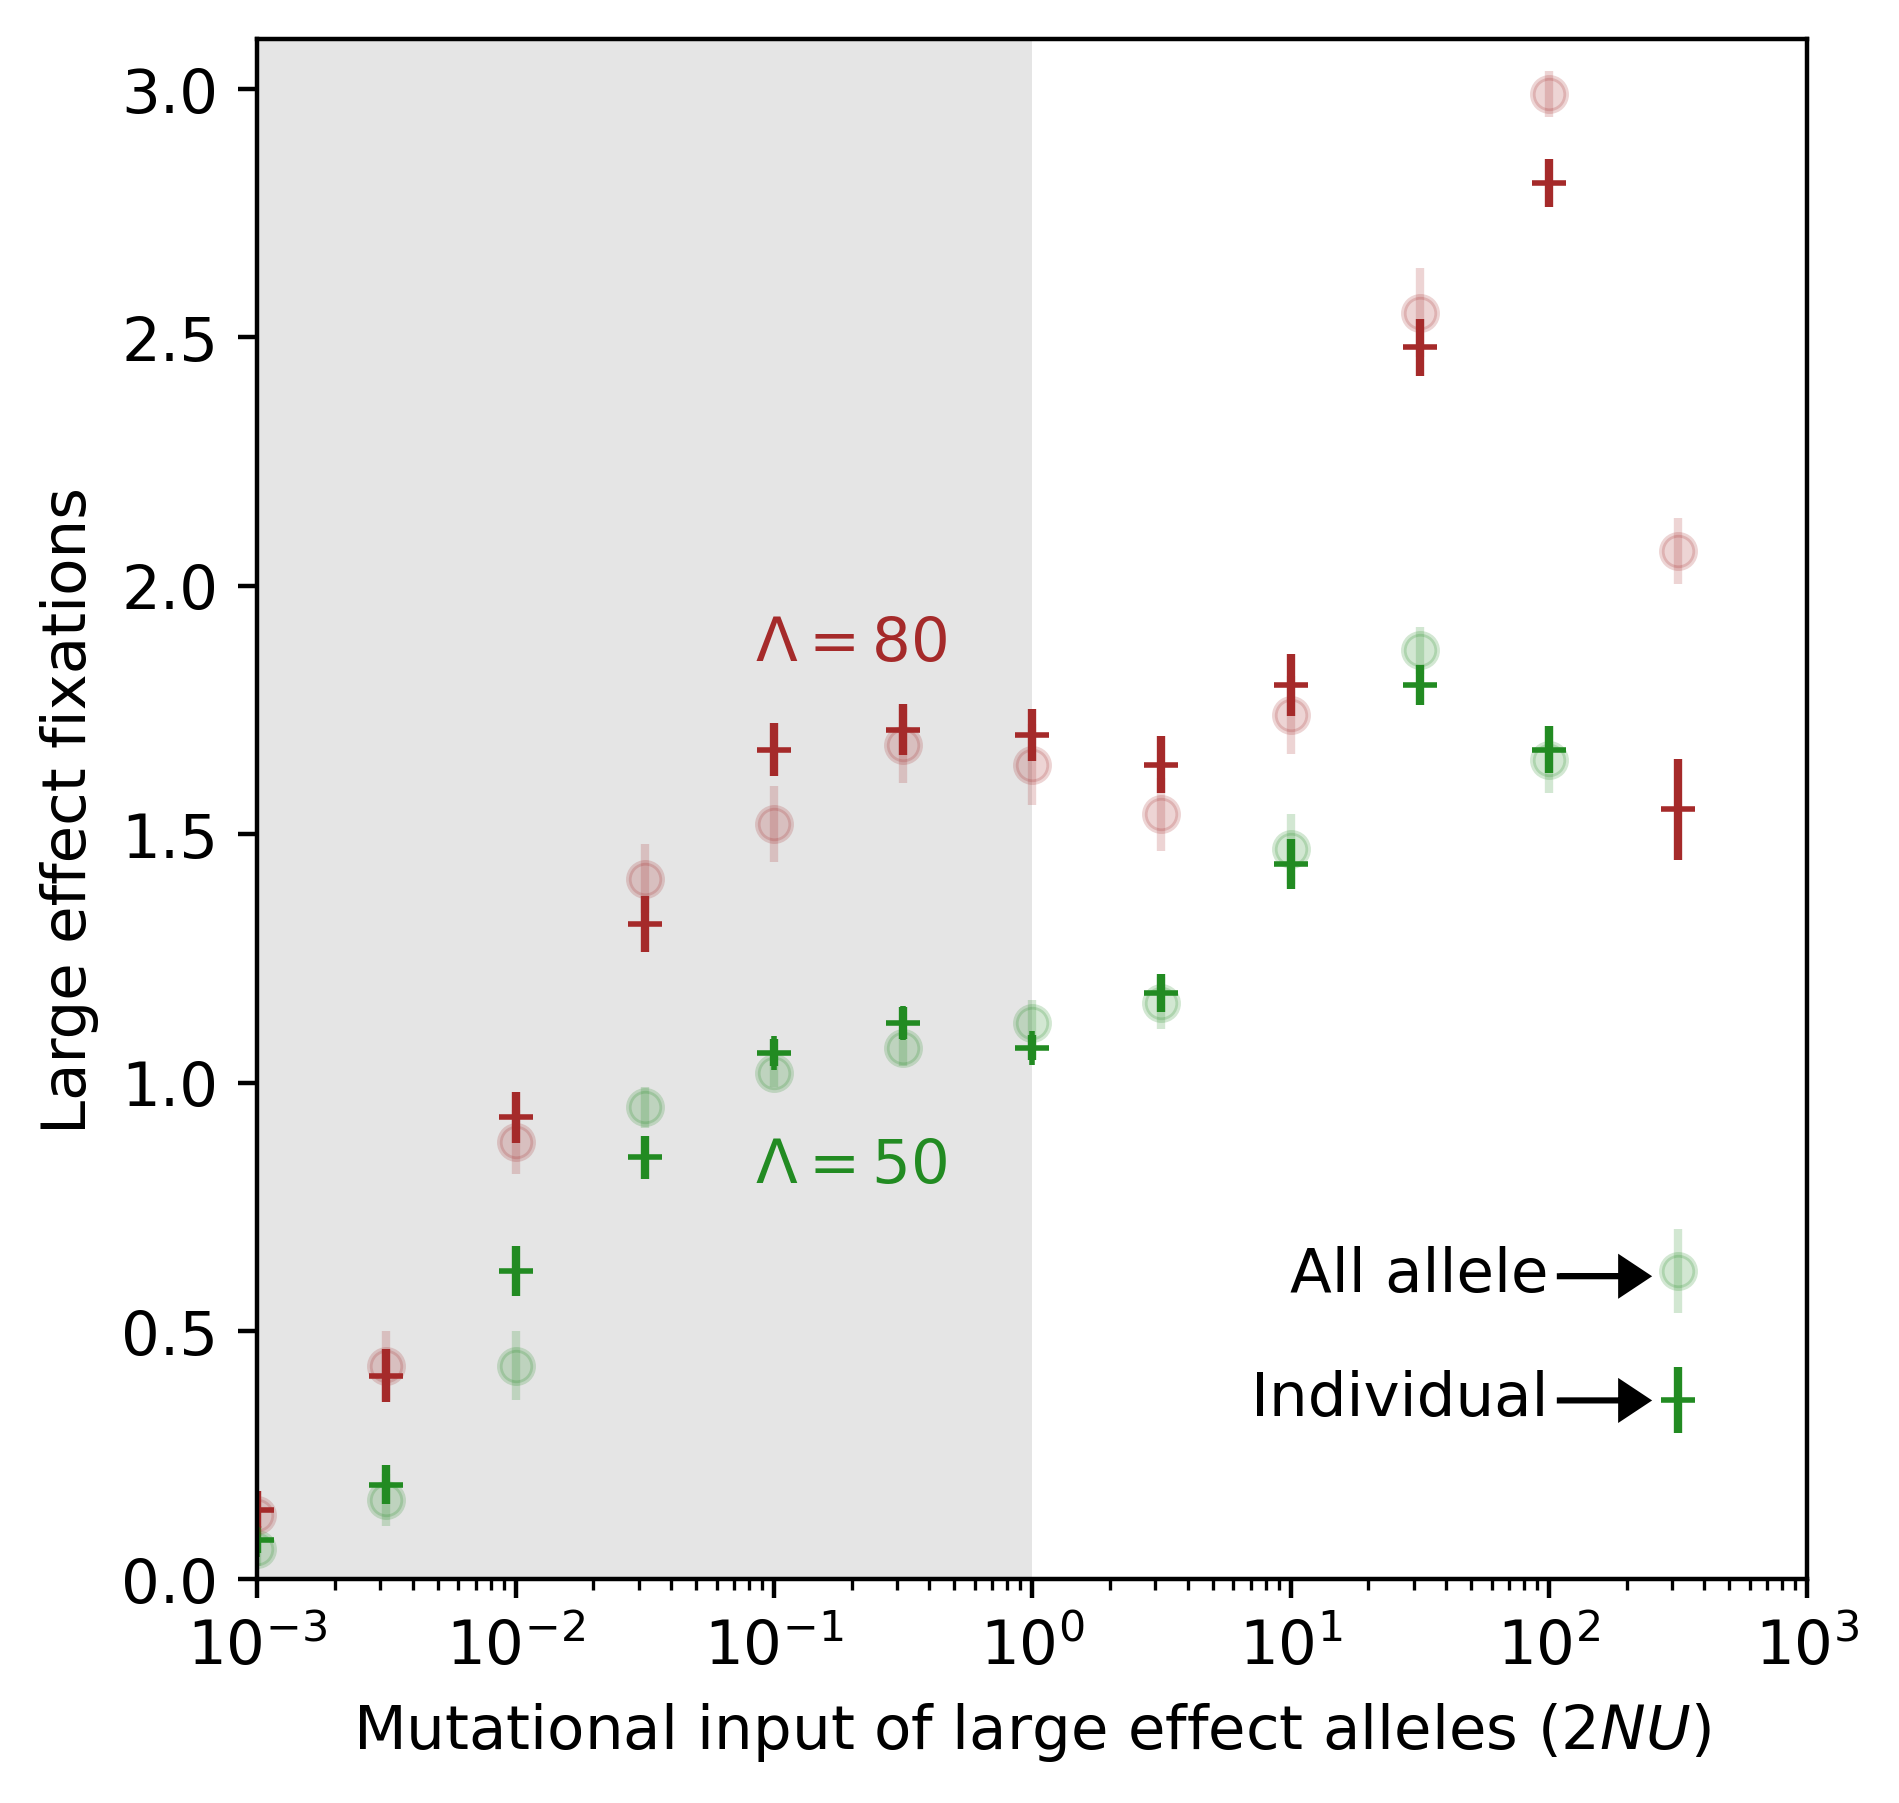

In [16]:
fig, tx1 = plt.subplots(nrows=1,ncols=1, figsize=(5, 5),dpi=400)
fontsize = 11
ax = tx1
ax.set_xscale('log')
ax.set_ylabel('Large effect fixations', fontsize=fontsize)
ax.set_xlabel(r'Mutational input of large effect alleles ($2NU$)', fontsize=fontsize)
ax.set_xlim(0.001,1000)
ax.set_ylim(0,3.1)
ax.fill_between([0.001,1],[0,0],[3.1,3.1],color='k',alpha=0.1,edgecolor='None')
for ax,title_label,title in zip([tx1],['A','B','C'],['Comparison of individual and all-allele simulations','Variance','Skewness']):
    title = ''
    ax.set_title(title, fontsize=fontsize,loc='left')
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)

plot_individual_fixations(tx1)
plot_all_allele_fixations(tx1,all_allele_results)
tx1.text(x=0.2,y=1.85,s=r'$\Lambda=80$',color='brown',fontsize=fontsize,horizontalalignment='center')
tx1.text(x=0.2,y=0.8,s=r'$\Lambda=50$',color='forestgreen',fontsize=fontsize,horizontalalignment='center')
tx1.text(x=100,y=0.58,s='All allele',color='k',fontsize=fontsize,horizontalalignment='right')
tx1.text(x=100,y=0.33,s='Individual',color='k',fontsize=fontsize,horizontalalignment='right')
tx1.arrow(110, 0.61, 80, 0, head_width=0.07, head_length=50, fc='k', ec='k',linewidth=1)
tx1.arrow(110, 0.36, 80, 0, head_width=0.07, head_length=50, fc='k', ec='k',linewidth=1)
plt.savefig('../Figures/Supplement_Figure_1.png', bbox_inches='tight',dpi=400)


<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2824366/2537133346.py:19: SyntaxWarning: invalid escape sequence '\m'
  title = '$\mathbf{'+title_label+'.}$'


File not found: /insomnia001/home/wm2377/cdwm/large_effect_alleles/data/all_alleles_simulations/sigma2_4/LargeN2U_1000.0/shift_50/better_skew_results.pkl
File not found: /insomnia001/home/wm2377/cdwm/large_effect_alleles/data/all_alleles_simulations/sigma2_4/LargeN2U_1000.0/shift_80/better_skew_results.pkl
File not found: /insomnia001/home/wm2377/cdwm/large_effect_alleles/data/all_alleles_simulations/sigma2_40/LargeN2U_1000.0/shift_50/better_skew_results.pkl
File not found: /insomnia001/home/wm2377/cdwm/large_effect_alleles/data/all_alleles_simulations/sigma2_40/LargeN2U_1000.0/shift_80/better_skew_results.pkl
File not found: /insomnia001/home/wm2377/cdwm/large_effect_alleles/data/all_alleles_simulations/sigma2_80/LargeN2U_1000.0/shift_50/better_skew_results.pkl
File not found: /insomnia001/home/wm2377/cdwm/large_effect_alleles/data/all_alleles_simulations/sigma2_80/LargeN2U_1000.0/shift_80/better_skew_results.pkl


/tmp/ipykernel_2824366/1889537396.py:32: RuntimeWarning: Mean of empty slice
  mean_values = np.nanmean(mean_array,axis=0)/(2*sigma2)
/tmp/ipykernel_2824366/1889537396.py:33: RuntimeWarning: Mean of empty slice
  ste_values = np.nanmean(ste_array,axis=0)/np.sqrt(len(ste_array))/(2*sigma2)


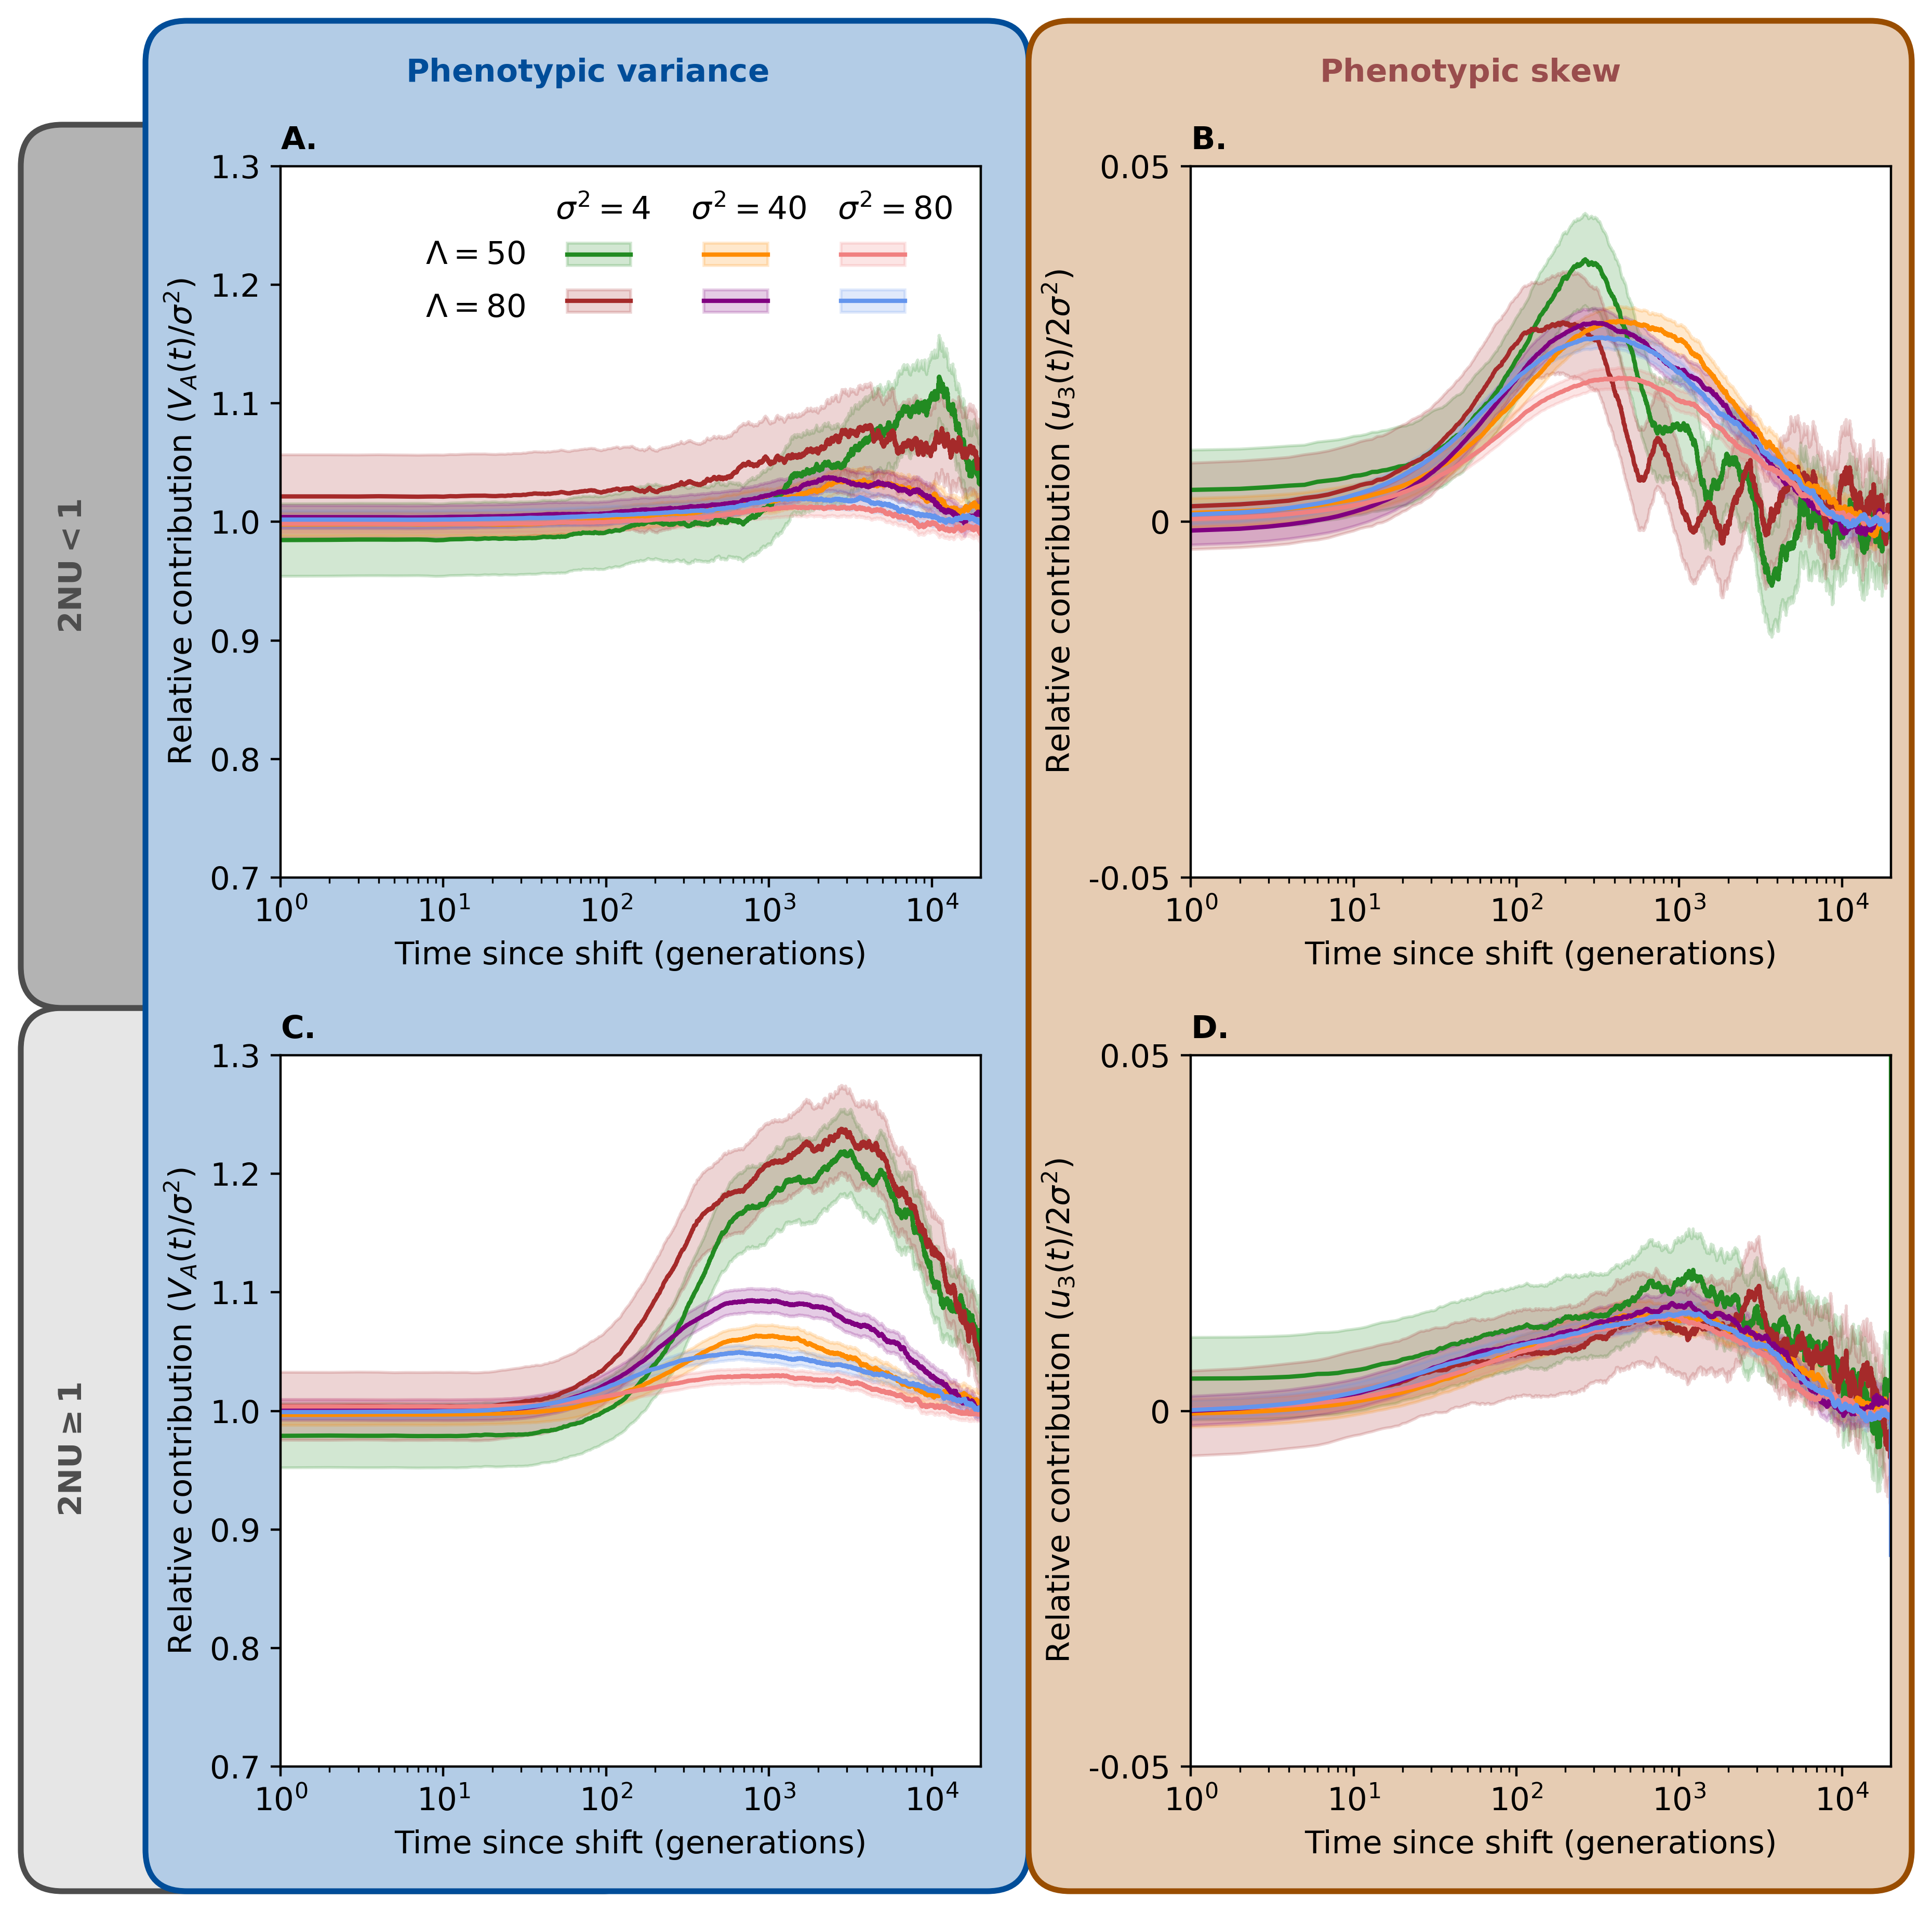

In [17]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(10,10),dpi=400)
plot_var_and_skew_group_2NU((ax1, ax2, ax3, ax4), all_allele_results, bin_value=100)
fontsize = 11

for ax in (ax1, ax2, ax3, ax4):
    
    ax.set_xscale('log')
    if ax in [ax1,ax2,ax3,ax4]:
        ax.set_xlabel('Time since shift (generations)', fontsize=fontsize)
        ax.set_xlim(1,19990)
        if ax in [ax1,ax3]:
            ax.set_ylim(0.7,1.3)
            ax.set_ylabel(r'Relative contribution ($V_A(t)/\sigma^2$)', fontsize=fontsize)
        elif ax in [ax2,ax4]:
            ax.set_ylim(0,0.3)
            ax.set_ylabel(r'Relative contribution ($u_3(t)/{2\sigma^2}$)', fontsize=fontsize)
    
for ax,title_label in zip([ax1,ax2,ax3,ax4],['A','B','C','D']):
    title = '$\mathbf{'+title_label+'.}$'
    ax.set_title(title, fontsize=fontsize,loc='left')
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)

legend_entries = {}
for sigma2 in [4,40,80]:
    for shift in [50,80]:
        color = color_function_2NU_x_axis(sigma2, shift)
        label = r'$\sigma2 = $'+f'{sigma2}, '+r'$\Lambda =$'+f'{shift}'
        g1 = plt.fill_between([], [], [], color=color,alpha=0.2)
        g2, = plt.plot([], [], color=color)
        legend_entries[label] = (g1,g2)
ax1.legend(handles=legend_entries.values(), labels = [" "]*len(legend_entries.keys()), loc='upper right', title=r'$\sigma^2=4$'+'    '+r'$\sigma^2=40$'+'   '+r'$\sigma^2=80$', fontsize=fontsize,ncols=3,frameon=False,title_fontsize=fontsize,columnspacing=1.2)
plt.subplots_adjust(hspace=0.25, wspace=0.3)

import matplotlib.patches as mpatches
fancybox_1 = mpatches.FancyBboxPatch(
        (0.06, 0.05),
        0.425,
        0.9,
        boxstyle='Round, pad=0,rounding_size=0.02',  # Example box style: round corners with padding
        mutation_aspect=1,
        clip_on=False,
        edgecolor=[0,0.3,0.6],
        facecolor=[0.7,0.8,0.9], # Make the box transparent inside
        linewidth=2,
        transform=fig.transFigure,# Crucial for aligning with figure coordinates
        zorder=-1 # Ensure the box is behind other plot elements
    )
fancybox_2 = mpatches.FancyBboxPatch(
        (0.425+0.06, 0.05),
        0.425,
        0.9,
        boxstyle='Round, pad=0,rounding_size=0.02',  # Example box style: round corners with padding
        mutation_aspect=1,
        clip_on=False,
        edgecolor=[0.6,0.3,0],
        facecolor=[0.9,0.8,0.7], # Make the box transparent inside
        linewidth=2,
        transform=fig.transFigure,# Crucial for aligning with figure coordinates
        zorder=-1 # Ensure the box is behind other plot elements
    )
fancybox_3 = mpatches.FancyBboxPatch(
        (0, 0.05),
        0.3,
        0.425,
        boxstyle='Round, pad=0,rounding_size=0.02',  # Example box style: round corners with padding
        mutation_aspect=1,
        clip_on=False,
        edgecolor=[0.3,0.3,0.3],
        facecolor=[0.9,0.9,0.9], # Make the box transparent inside
        linewidth=2,
        transform=fig.transFigure,# Crucial for aligning with figure coordinates
        zorder=-2 # Ensure the box is behind other plot elements
    )

fancybox_4 = mpatches.FancyBboxPatch(
        (0, 0.475),
        0.3,
        0.425,
        boxstyle='Round, pad=0,rounding_size=0.02',  # Example box style: round corners with padding
        mutation_aspect=1,
        clip_on=False,
        edgecolor=[0.3,0.3,0.3],
        facecolor=[0.7,0.7,0.7], # Make the box transparent inside
        linewidth=2,
        transform=fig.transFigure,# Crucial for aligning with figure coordinates
        zorder=-2 # Ensure the box is behind other plot elements
    )
fig.patches.append(fancybox_1)  # Add the patch to the figure with a low z-order
fig.patches.append(fancybox_2)  # Add the patch to the figure with a low z-order
fig.patches.append(fancybox_3)  # Add the patch to the figure with a low z-order
fig.patches.append(fancybox_4)  # Add the patch to the figure with a low z-order

# put text in vertical center of fancybox_4 and horizontally in the center between where fancybox_4 and fancybox_1 meet
fig.text(x=0.025,y=0.475+0.425/2,s=r'$\bf{2NU < 1}$',color=[0.3,0.3,0.3],fontsize=fontsize,horizontalalignment='center',verticalalignment='center',rotation=90)
fig.text(x=0.025,y=0.05+0.425/2,s=r'$\bf{2NU \geq 1}$',color=[0.3,0.3,0.3],fontsize=fontsize,horizontalalignment='center',verticalalignment='center',rotation=90)
# put text in horizontal center of fancybox_1 and vertically in the center between where fancybox_4 and fancybox_1 meet
fig.text(x=0.06+0.425/2,y=(0.95+(0.475+0.425))/2,s=r'$\bf{Phenotypic\ variance}$',color=[0,0.3,0.6],fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
fig.text(x=(0.425+0.06)+0.425/2,y=(0.95+(0.475+0.425))/2,s=r'$\bf{Phenotypic\ skew}$',color=[0.6,0.3,0.3],fontsize=fontsize,horizontalalignment='center',verticalalignment='center')

ax1.text(x=32,y=1.225,s=r'$\Lambda=50$',color='k',fontsize=fontsize,verticalalignment='center',horizontalalignment='right')
ax1.text(x=32,y=1.18,s=r'$\Lambda=80$',color='k',fontsize=fontsize,verticalalignment='center',horizontalalignment='right')

plot_skew(ax_small=ax2,ax_large=ax4)
for ax in [ax2, ax4]:
    ax.set_yticks([-0.05,0,0.05])
    ax.set_yticklabels(['-0.05','0','0.05'])
plt.savefig('../Figures/Supplement_Figure_2.png', bbox_inches='tight',dpi=400)

